# Tasks

### Install packages

In [1]:
!pip install mpl_tools scikit-learn matplotlib seaborn conllu seqeval


## 1. Dataset Exploration

In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os, requests # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='seqeval')

### Load the Dataset

In [3]:
# Optional: Auto-download UD English EWT r2.14 from official repo
# If you already have the Kaggle files, skip this cell.

DATA_DIR = Path('data/ud_en')
DATA_DIR.mkdir(parents=True, exist_ok=True)

base = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/r2.14'
files = {
    'train.conllu': 'en_ewt-ud-train.conllu',
    'dev.conllu':   'en_ewt-ud-dev.conllu',
    'test.conllu':  'en_ewt-ud-test.conllu',
}

for out_name, src_name in files.items():
    out_path = DATA_DIR/out_name
    if not out_path.exists():
        url = f"{base}/{src_name}"
        print('Downloading', url)
        r = requests.get(url)
        r.raise_for_status()
        out_path.write_bytes(r.content)

print('Data files present:', list(DATA_DIR.iterdir()))


Data files present: [WindowsPath('data/ud_en/dev.conllu'), WindowsPath('data/ud_en/test.conllu'), WindowsPath('data/ud_en/train.conllu')]


In [4]:
# Basic stats and samples from UD English EWT dataset

from conllu import parse_incr
from pathlib import Path
from collections import Counter
import random

DATA_DIR = Path('data/ud_en')
TRAIN = DATA_DIR/'train.conllu'
DEV   = DATA_DIR/'dev.conllu'
TEST  = DATA_DIR/'test.conllu'
assert TRAIN.exists() and DEV.exists() and TEST.exists(), 'Missing .conllu files in data/ud_en/'


def read_conllu(path):
    with open(path, 'r', encoding='utf-8') as f:
        for sent in parse_incr(f):
            tokens = [t['form'] for t in sent if isinstance(t['id'], int)]
            tags   = [t['upostag'] for t in sent if isinstance(t['id'], int)]
            yield tokens, tags

train = list(read_conllu(TRAIN))
dev   = list(read_conllu(DEV))
test  = list(read_conllu(TEST))

len_train, len_dev, len_test = len(train), len(dev), len(test)
print(f"Number of sentences (train) : {len_train}")
print(f"Number of sentences (dev) : {len_dev}")
print(f"Number of sentences (test) : {len_test}")

Number of sentences (train) : 12544
Number of sentences (dev) : 2001
Number of sentences (test) : 2077


### Analyze

#### Number of sentences and tokens

In [5]:
all_sents = train + dev + test
num_sentences = len(all_sents)
num_tokens = sum(len(s[0]) for s in all_sents)
avg_len = num_tokens / num_sentences

print(f"Total sentences: {num_sentences}")
print(f"Total tokens: {num_tokens}")


Total sentences: 16622
Total tokens: 254821


#### POS tag distribution

Convert the data into a suitable format for training a sequence labeling model (POS tagging)

In [6]:
tag_counter = Counter(tag for _, tags in all_sents for tag in tags)

for tag, c in tag_counter.most_common(20):
    print(f"{tag:>5}: {c}")

 NOUN: 43156
PUNCT: 29768
 VERB: 27890
 PRON: 23044
  ADP: 21866
  DET: 20098
  ADJ: 16812
PROPN: 16563
  AUX: 15924
  ADV: 12507
CCONJ: 8204
 PART: 7044
  NUM: 5052
SCONJ: 4603
 INTJ: 930
  SYM: 913
    X: 447


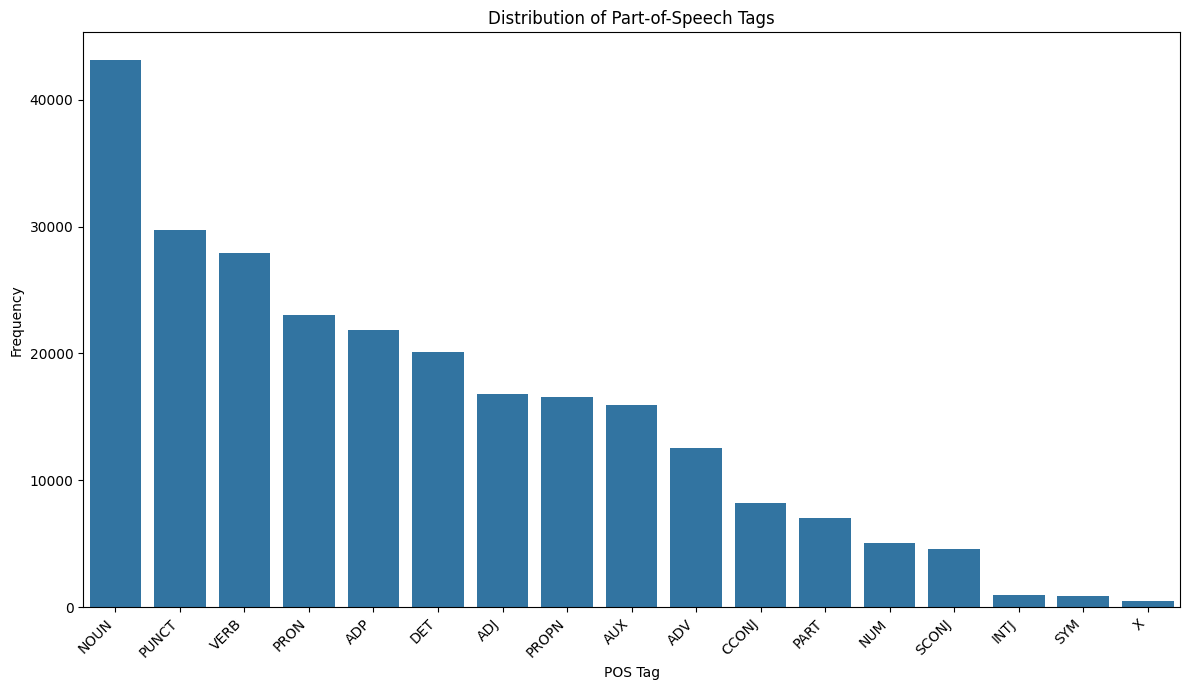

In [7]:
import pandas as pd
import seaborn as sns

# Convert the tag_counter to a DataFrame for easier plotting
tag_df = pd.DataFrame(tag_counter.most_common(), columns=['Tag', 'Count'])

plt.figure(figsize=(12, 7))
sns.barplot(x='Tag', y='Count', data=tag_df)
plt.title('Distribution of Part-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Average sentence lengths

In [8]:
print(f"Average sentence length: {avg_len:.2f}")

Average sentence length: 15.33


### Sample

In [9]:
print("Tokens with UPOS tags for five random sentences:")
for num in range(5):
    tokenSentence, tagSentence = random.choice(all_sents)
    print(f"Random Sentence {num+1}:",end="\n")
    for token, tag in zip(tokenSentence, tagSentence):
        print(f"{token} [{tag}]",end=" ")
    print("\n")


Tokens with UPOS tags for five random sentences:
Random Sentence 1:
He [PRON] is [AUX] a [DET] few [ADJ] years [NOUN] older [ADJ] than [ADP] me [PRON] . [PUNCT] 

Random Sentence 2:
- [PUNCT] better [ADJ] food [NOUN] 

Random Sentence 3:
about [ADP] our [PRON] lifestyle [NOUN] ... [PUNCT] 

Random Sentence 4:
The [DET] Hatfill [PROPN] theory [NOUN] -- [PUNCT] to [PART] include [VERB] ongoing [ADJ] interviews [NOUN] and [CCONJ] ongoing [ADJ] 7 [NUM] / [PUNCT] 24 [NUM] surveillance [NOUN] by [ADP] 8 [NUM] surveillance [NOUN] specialists [NOUN] -- [PUNCT] is [AUX] now [ADV] the [DET] subject [NOUN] of [ADP] pending [ADJ] civil [ADJ] rights [NOUN] and [CCONJ] libel [NOUN] claims [NOUN] of [ADP] uncertain [ADJ] merit [NOUN] . [PUNCT] 

Random Sentence 5:
Great [ADJ] Food [NOUN] Awesome [ADJ] food [NOUN] Awesome [ADJ] service [NOUN] 



In [10]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from seqeval.metrics import classification_report, accuracy_score, f1_score

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'


def build_vocab(sentences, min_freq=1):
    wc = Counter(tok.lower() for toks, _ in sentences for tok in toks)
    itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, c in wc.items() if c >= min_freq]
    stoi = {w:i for i, w in enumerate(itos)}
    return stoi, itos


def build_tag_map(sentences):
    tags = sorted({t for _, ts in sentences for t in ts})
    tag2id = {t:i for i, t in enumerate(tags)}
    id2tag = {i:t for t, i in tag2id.items()}
    return tag2id, id2tag


word2id, id2word = build_vocab(train)
tag2id, id2tag   = build_tag_map(train)
PAD_ID = word2id[PAD_TOKEN]


MAX_LEN = 128


def vectorize(tokens, tags=None, max_len=MAX_LEN):
    ids = [word2id.get(tok.lower(), word2id[UNK_TOKEN]) for tok in tokens]
    tids = None
    if tags is not None:
        tids = [tag2id[t] for t in tags]
    if max_len is not None:
        ids = ids[:max_len]
        if tids is not None:
            tids = tids[:max_len]
    return ids, tids


class SeqDataset(Dataset):
    def __init__(self, samples, max_len=MAX_LEN):
        self.samples = samples
        self.max_len = max_len
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        tokens, tags = self.samples[idx]
        wi, ti = vectorize(tokens, tags, self.max_len)
        return wi, ti


def collate(batch):
    xs, ys = zip(*batch)
    max_len = max(len(x) for x in xs)
    px = [x + [PAD_ID]*(max_len-len(x)) for x in xs]
    py = [y + [-100]*(max_len-len(y)) for y in ys]  # -100 ignored in CrossEntropyLoss
    attn = [[1]*len(x) + [0]*(max_len-len(x)) for x in xs]
    return (torch.tensor(px, dtype=torch.long),
            torch.tensor(py, dtype=torch.long),
            torch.tensor(attn, dtype=torch.bool))


train_dl = DataLoader(SeqDataset(train), batch_size=64, shuffle=True, collate_fn=collate)
dev_dl   = DataLoader(SeqDataset(dev),   batch_size=128, shuffle=False, collate_fn=collate)
test_dl  = DataLoader(SeqDataset(test),  batch_size=128, shuffle=False, collate_fn=collate)


def evaluate_sequences(true_ids, pred_ids):
    all_true, all_pred = [], []
    for y, p in zip(true_ids, pred_ids):
        y_tags = [id2tag[i] for i in y]
        p_tags = [id2tag[i] for i in p]
        all_true.append(y_tags)
        all_pred.append(p_tags)
    acc = accuracy_score(all_true, all_pred)
    macro_f1 = f1_score(all_true, all_pred, average='macro')
    micro_f1 = f1_score(all_true, all_pred, average='micro')
    report = classification_report(all_true, all_pred, digits=4)
    return acc, macro_f1, micro_f1, report


## Baseline POS tagger

In [11]:
import os, random, statistics, math
from collections import Counter
import numpy as np
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [12]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, num_tags, emb_dim=100, hidden_dim=256, num_layers=1, dropout=0.2, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_tags)

    def forward(self, x, mask=None):
        e = self.emb(x)                     # (B, T, E)
        out, _ = self.lstm(e)               # (B, T, H)
        out = self.dropout(out)
        logits = self.fc(out)               # (B, T, C)
        return logits


def train_epoch(model, dl, optimizer, criterion):
    model.train()
    total = 0.0
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        optimizer.zero_grad()
        logits = model(X, M)
        loss = criterion(logits.view(-1, logits.size(-1)), Y.view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
    return total / max(1, len(dl))

@torch.no_grad()
def evaluate_model(model, dl):
    model.eval()
    all_true, all_pred = [], []
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        logits = model(X, M)
        pred = logits.argmax(-1)
        for y, p, m in zip(Y, pred, M):
            y = y[m].tolist()
            p = p[m].tolist()
            all_true.append(y)
            all_pred.append(p)
    acc, macro_f1, micro_f1, report = evaluate_sequences(all_true, all_pred)
    return acc, macro_f1, micro_f1, report

### Train Baseline POS Tagger

In [13]:
model_baseline = BiLSTMTagger(vocab_size=len(id2word), num_tags=len(tag2id), pad_idx=PAD_ID).to(device)
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

EPOCHS = 8
for epoch in range(EPOCHS):
    tr_loss = train_epoch(model_baseline, train_dl, optimizer, criterion)
    accuracy, mF1, uF1, report = evaluate_model(model_baseline, dev_dl)
    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | dev_acc={accuracy:.4f} | dev_macroF1={mF1:.4f}")

d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: DET seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\

Epoch 01 | train_loss=0.7804 | dev_acc=0.8551 | dev_macroF1=0.7497
Epoch 02 | train_loss=0.3010 | dev_acc=0.8983 | dev_macroF1=0.7986
Epoch 03 | train_loss=0.1800 | dev_acc=0.9042 | dev_macroF1=0.8071
Epoch 04 | train_loss=0.1118 | dev_acc=0.9105 | dev_macroF1=0.8142
Epoch 05 | train_loss=0.0691 | dev_acc=0.9110 | dev_macroF1=0.8157
Epoch 06 | train_loss=0.0435 | dev_acc=0.9109 | dev_macroF1=0.8134
Epoch 07 | train_loss=0.0276 | dev_acc=0.9098 | dev_macroF1=0.8205
Epoch 08 | train_loss=0.0189 | dev_acc=0.9111 | dev_macroF1=0.8209


### Train accuracy

In [14]:
print(f"Dev Accuracy : {100*accuracy:.3} %")
print(f"Dev report (Baseline): {report}")

Dev Accuracy : 91.1 %
Dev report (Baseline):               precision    recall  f1-score   support

         ART     0.9761    0.9459    0.9608       647
        CONJ     0.9656    0.9183    0.9414      1163
          DJ     0.8762    0.8518    0.8638      1761
          DP     0.9222    0.9634    0.9424      1994
          DV     0.7486    0.8291    0.7868      1106
         ERB     0.9299    0.8934    0.9113      2656
          ET     0.9804    0.9872    0.9838      1879
         NTJ     0.8889    0.7143    0.7921       112
         OUN     0.8282    0.8469    0.8375      3711
         RON     0.9801    0.9842    0.9821      2150
        ROPN     0.6755    0.5765    0.6221      1419
          UM     0.6805    0.8338    0.7494       355
        UNCT     0.9398    0.9813    0.9601      2945
          UX     0.9813    0.9753    0.9783      1455
          YM     0.8000    0.6747    0.7320        83
           _     0.3333    0.0526    0.0909        19

   micro avg     0.8971    0.8981  

### Test accuracy

In [15]:
test_accuracy, mF1_t, uF1_t, test_report = evaluate_model(model_baseline, test_dl)
print(f"Test Accuracy: {test_accuracy*100:.3} %")
print("Test Report (Baseline):", test_report)

Test Accuracy: 91.5 %
Test Report (Baseline):               precision    recall  f1-score   support

         ART     0.9699    0.9504    0.9601       645
        CONJ     0.9674    0.9378    0.9524      1109
          DJ     0.8777    0.8560    0.8667      1694
          DP     0.9330    0.9624    0.9475      1969
          DV     0.7748    0.8711    0.8201      1078
         ERB     0.9358    0.9027    0.9190      2569
          ET     0.9867    0.9883    0.9875      1874
         NTJ     0.9135    0.8051    0.8559       118
         OUN     0.8281    0.8522    0.8399      3578
         RON     0.9803    0.9868    0.9835      2114
        ROPN     0.7005    0.6050    0.6493      1562
          UM     0.7058    0.7580    0.7310       500
        UNCT     0.9389    0.9848    0.9613      2967
          UX     0.9818    0.9838    0.9828      1422
          YM     0.8476    0.8165    0.8318       109
           _     0.0000    0.0000    0.0000        16

   micro avg     0.9005    0.9034 

## 3. Contextual Embedding-Based POS Tagger (BERT)

In [16]:
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification, DataCollatorForTokenClassification,
    TrainingArguments, Trainer
)
from seqeval.metrics import (
    accuracy_score,
    classification_report,
    f1_score)


d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocess and encode

In [17]:
class HFTokenDataset(torch.utils.data.Dataset):
    def __init__(self, enc):
        self.enc = enc
    def __len__(self): return len(self.enc['input_ids'])
    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k,v in self.enc.items()}

# convert it into hugging face dict
def to_hf_dict(sentences):
    return {"tokens":[text for text, _ in sentences], "tags":[u for _, u in sentences]}


# Create mappings between label and ids
label_list = [id2tag[i] for i in range(len(id2tag))]
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

# This function tokenizes input sequences and aligns their corresponding labels (POS tags)
# for use with Hugging Face token classification models. It handles subword tokenization
# by assigning the original label to the first subword token and -100 to subsequent
# subword tokens and special tokens, which tells the model to ignore them during loss computation.
def encode_dataset(data, tokenizer):
    encoded = tokenizer(data['tokens'], is_split_into_words=True, truncation=True, padding=False, max_length=128)
    all_labels = []
    for i in range(len(data['tokens'])):
        word_ids = encoded.word_ids(batch_index=i)
        labels = data['tags'][i]
        aligned = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned.append(-100)
            else:
                if word_id != prev_word_id:
                    aligned.append(label2id[labels[word_id]])
                else:
                    aligned.append(-100)
                prev_word_id = word_id
        all_labels.append(aligned)
    encoded['labels'] = all_labels
    return encoded

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    true_seqs, pred_seqs = [], []
    for p, l in zip(preds, labels):
        y, yh = [], []
        for pi, li in zip(p, l):
            if li != -100:
                y.append(id2label[int(li)])
                yh.append(id2label[int(pi)])
        true_seqs.append(y)
        pred_seqs.append(yh)
    return {"accuracy": accuracy_score(true_seqs, pred_seqs)}

In [18]:
# Use bert based tokenizer
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_hf, dev_hf, test_hf = to_hf_dict(train), to_hf_dict(dev), to_hf_dict(test)

train_encoder = encode_dataset(train_hf, tokenizer)
dev_encoder   = encode_dataset(dev_hf, tokenizer)
test_encoder  = encode_dataset(test_hf, tokenizer)

# Create dataset in hugging face format suitable for transformers
train_ds = HFTokenDataset(train_encoder)
dev_ds   = HFTokenDataset(dev_encoder)
test_ds  = HFTokenDataset(test_encoder)

### Initialize BERT model

In [19]:
# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Classifier
model_ctx = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
).to(device)

# Training args
args = TrainingArguments(
    output_dir='outputs/bert-pos',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    report_to=[]
)

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 838.17it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForTokenClassification LOAD REPORT from: bert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can b

### Train BERT classifier

In [20]:
trainer = Trainer(
    model=model_ctx,
    args=args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.077554,0.103712,0.970854
2,0.035662,0.102789,0.972961
3,0.020978,0.109884,0.974790
4,0.007530,0.120799,0.975506


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


TrainOutput(global_step=3136, training_loss=0.059751928023689865, metrics={'train_runtime': 212.1438, 'train_samples_per_second': 236.519, 'train_steps_per_second': 14.782, 'total_flos': 1377441152226336.0, 'train_loss': 0.059751928023689865, 'epoch': 4.0})

### Evaluate

#### Train metrics

In [21]:
metrics_dev = trainer.evaluate()
print('Dev metrics:', metrics_dev)

Dev metrics: {'eval_loss': 0.12079888582229614, 'eval_accuracy': 0.9755059843333731, 'eval_runtime': 1.4615, 'eval_samples_per_second': 1369.108, 'eval_steps_per_second': 43.105, 'epoch': 4.0}


Test metrics

In [22]:
pred_output = trainer.predict(test_ds)
logits = pred_output.predictions
labels = pred_output.label_ids
preds = np.argmax(logits, axis=-1)

true_seqs, pred_seqs = [], []
for p, l in zip(preds, labels):
    y, yh = [], []
    for pi, li in zip(p, l):
        if li != -100:
            y.append(id2label[int(li)])
            yh.append(id2label[int(pi)])
    true_seqs.append(y)
    pred_seqs.append(yh)

print('BERT Test Accuracy:', accuracy_score(true_seqs, pred_seqs))
print('BERT Test macro-F1:', f1_score(true_seqs, pred_seqs, average='macro'))
print('BERT Test micro-F1:', f1_score(true_seqs, pred_seqs, average='micro'))
print('BERT TEST REPORT:', classification_report(true_seqs, pred_seqs, digits=4))


BERT Test Accuracy: 0.97561170000797
BERT Test macro-F1: 0.908685191640308
BERT Test micro-F1: 0.970803544672289


d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PRON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: SCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment

BERT TEST REPORT:               precision    recall  f1-score   support

         ART     0.9969    0.9953    0.9961       645
        CONJ     0.9874    0.9865    0.9869      1109
          DJ     0.9432    0.9404    0.9418      1694
          DP     0.9793    0.9837    0.9815      1969
          DV     0.9470    0.9453    0.9461      1078
         ERB     0.9807    0.9903    0.9855      2569
          ET     0.9936    0.9947    0.9941      1874
         NTJ     0.9292    0.8898    0.9091       118
         OUN     0.9378    0.9516    0.9447      3578
         RON     0.9925    0.9967    0.9946      2114
        ROPN     0.9108    0.8956    0.9032      1562
          UM     0.9559    0.9960    0.9755       500
        UNCT     0.9973    0.9939    0.9956      2967
          UX     0.9979    0.9958    0.9968      1422
          YM     0.8455    0.9541    0.8966       109
           _     0.1667    0.0625    0.0909        16

   micro avg     0.9694    0.9723    0.9708     23324
   macro

# 4. Attention-Based POS Tagger

Bi-LSTM with Attention Model

In [23]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, num_tags, emb_dim=100, hidden_dim=256, pad_idx=0, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.W_q = nn.Linear(hidden_dim, hidden_dim)
        self.W_k = nn.Linear(hidden_dim, hidden_dim)
        self.v   = nn.Linear(hidden_dim, 1, bias=False)
        self.fc  = nn.Linear(hidden_dim*2, num_tags)  # concat [h_t ; context_t]

    def forward(self, x, mask):
        h, _ = self.lstm(self.emb(x))             # (B, T, H)
        h = self.dropout(h)
        Q = self.W_q(h)                            # (B, T, H)
        K = self.W_k(h)                            # (B, T, H)

        B, T, H = Q.size()
        Qe = Q.unsqueeze(2).expand(B, T, T, H)
        Ke = K.unsqueeze(1).expand(B, T, T, H)
        scores = self.v(torch.tanh(Qe + Ke)).squeeze(-1)  # (B, T, T)

        key_mask = mask.unsqueeze(1).expand(B, T, T)      # (B, T, T)
        scores = scores.masked_fill(~key_mask, -1e9)

        attn = torch.softmax(scores, dim=-1)              # (B, T, T)
        context = attn @ h                                 # (B, T, H)

        out = torch.cat([h, context], dim=-1)             # (B, T, 2H)
        logits = self.fc(self.dropout(out))               # (B, T, C)
        return logits, attn

def train_epoch_attn(model, dl, optimizer, criterion):
    model.train()
    total = 0.0
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        optimizer.zero_grad()
        logits, attn = model(X, M)
        loss = criterion(logits.view(-1, logits.size(-1)), Y.view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
    return total / max(1, len(dl))

@torch.no_grad()
def evaluate_model_attn(model, dl):
    model.eval()
    all_true, all_pred = [], []
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        logits, attn = model(X, M)
        pred = logits.argmax(-1)
        for y, p, m in zip(Y, pred, M):
            y = y[m].tolist()
            p = p[m].tolist()
            all_true.append(y)
            all_pred.append(p)
    acc, macro_f1, micro_f1, report = evaluate_sequences(all_true, all_pred)
    return acc, macro_f1, micro_f1, report

Train model

In [36]:
model_attn = BiLSTMWithAttention(vocab_size=len(id2word), num_tags=len(tag2id), pad_idx=PAD_ID).to(device)
opt_attn = torch.optim.AdamW(model_attn.parameters(), lr=3e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss(ignore_index=-100)

EPOCHS_ATTN = 8
for epoch in range(EPOCHS_ATTN):
    tr_loss = train_epoch_attn(model_attn, train_dl, opt_attn, crit)
    acc, mF1, uF1, rep = evaluate_model_attn(model_attn, dev_dl)
    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | dev_acc={acc:.4f} | dev_macroF1={mF1:.4f}")





d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: DET seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\

Epoch 01 | train_loss=0.7970 | dev_acc=0.8552 | dev_macroF1=0.7495
Epoch 02 | train_loss=0.3133 | dev_acc=0.8918 | dev_macroF1=0.7971
Epoch 03 | train_loss=0.1966 | dev_acc=0.9029 | dev_macroF1=0.8099
Epoch 04 | train_loss=0.1293 | dev_acc=0.9108 | dev_macroF1=0.8200
Epoch 05 | train_loss=0.0866 | dev_acc=0.9120 | dev_macroF1=0.8219
Epoch 06 | train_loss=0.0600 | dev_acc=0.9115 | dev_macroF1=0.8275
Epoch 07 | train_loss=0.0436 | dev_acc=0.9118 | dev_macroF1=0.8252
Epoch 08 | train_loss=0.0327 | dev_acc=0.9148 | dev_macroF1=0.8332


In [37]:
print("DEV ACC:", acc)
print("DEV REPORT (BiLSTM+Attention):\n", rep)

DEV ACC: 0.9147878643286015
DEV REPORT (BiLSTM+Attention):
               precision    recall  f1-score   support

         ART     0.9793    0.9505    0.9647       647
        CONJ     0.9491    0.9295    0.9392      1163
          DJ     0.8884    0.8359    0.8613      1761
          DP     0.9226    0.9624    0.9421      1994
          DV     0.9046    0.8228    0.8617      1106
         ERB     0.9203    0.8870    0.9034      2656
          ET     0.9794    0.9878    0.9836      1879
         NTJ     0.9512    0.6964    0.8041       112
         OUN     0.7822    0.8604    0.8195      3711
         RON     0.9788    0.9865    0.9826      2150
        ROPN     0.6732    0.6096    0.6398      1419
          UM     0.8068    0.8000    0.8034       355
        UNCT     0.9932    0.9874    0.9903      2945
          UX     0.9841    0.9808    0.9824      1455
          YM     0.8451    0.7229    0.7792        83
           _     0.1250    0.0526    0.0741        19

   micro avg     0.9

In [38]:
acc_t2, mF1_t2, uF1_t2, rep_t2 = evaluate_model_attn(model_attn, test_dl)
print("TEST ACC:", acc_t2)
print("TEST REPORT (BiLSTM+Attention):\n", rep_t2)

TEST ACC: 0.9184665657129194
TEST REPORT (BiLSTM+Attention):
               precision    recall  f1-score   support

         ART     0.9750    0.9690    0.9720       645
        CONJ     0.9603    0.9387    0.9494      1109
          DJ     0.8933    0.8300    0.8605      1694
          DP     0.9330    0.9614    0.9470      1969
          DV     0.9125    0.8516    0.8810      1078
         ERB     0.9367    0.9105    0.9234      2569
          ET     0.9804    0.9872    0.9838      1874
         NTJ     0.9583    0.7797    0.8598       118
         OUN     0.7875    0.8617    0.8229      3578
         RON     0.9779    0.9844    0.9811      2114
        ROPN     0.6796    0.6300    0.6538      1562
          UM     0.8031    0.7260    0.7626       500
        UNCT     0.9939    0.9835    0.9886      2967
          UX     0.9852    0.9810    0.9831      1422
          YM     0.8103    0.8624    0.8356       109
           _     0.0000    0.0000    0.0000        16

   micro avg     0

Visualization of attention weights

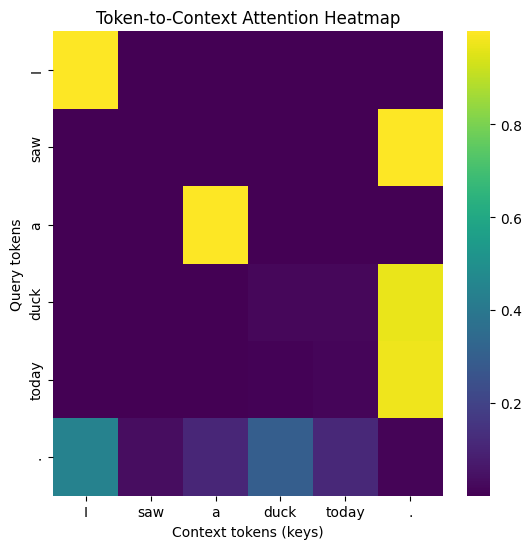

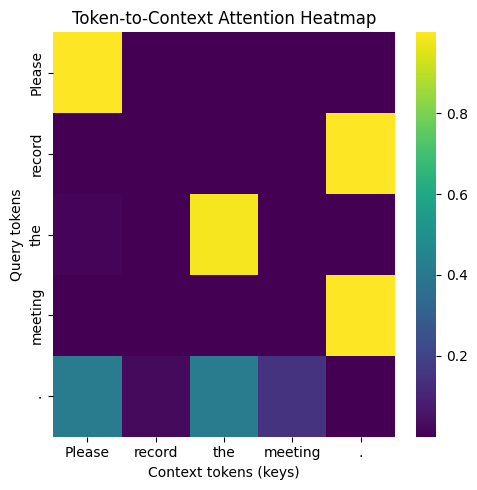

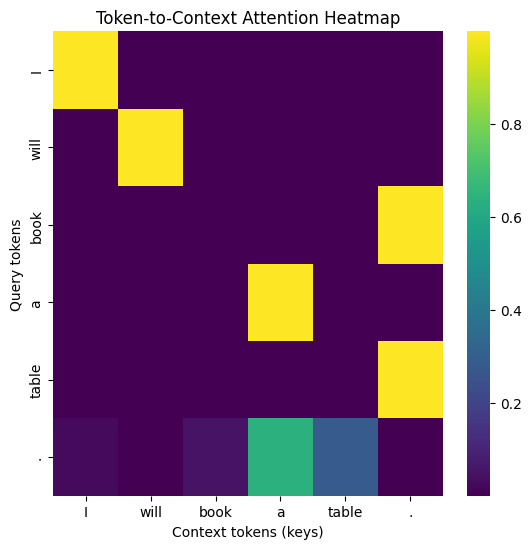

In [39]:
@torch.no_grad()
def visualize_attention(model, sentence_tokens):
    model.eval()
    wi, _ = vectorize(sentence_tokens, None, max_len=MAX_LEN)
    X = torch.tensor([wi], dtype=torch.long).to(device)
    M = torch.tensor([[1]*len(sentence_tokens)], dtype=torch.bool).to(device)
    logits, attn = model(X, M)
    T = len(sentence_tokens)
    mat = attn[0, :T, :T].detach().cpu().numpy()
    plt.figure(figsize=(min(0.6*T+2, 12), min(0.6*T+2, 12)))
    sns.heatmap(mat, xticklabels=sentence_tokens, yticklabels=sentence_tokens, cmap='viridis')
    plt.title('Token-to-Context Attention Heatmap')
    plt.xlabel('Context tokens (keys)')
    plt.ylabel('Query tokens')
    plt.tight_layout()
    plt.show()


# Examples with ambiguity
examples = [
    ["I","saw","a","duck","today","."],
    ["Please","record","the","meeting","."],
    ["I","will","book","a","table","."]
]
for ex in examples:
    visualize_attention(model_attn, ex)


### Analyzing Attention for POS Ambiguity Resolution

In [40]:
ambiguous_cases = {
    "duck": [
        (["I", "saw", "a", "duck", "today", "."], 3, "NOUN"),
        (["Duck", "your", "head", "now", "!"], 0, "VERB"),
    ],
    "record": [
        (["Please", "record", "the", "meeting", "."], 1, "VERB"),
        (["Play", "the", "record", "loudly", "."], 2, "NOUN"),
    ],
    "book": [
        (["I", "will", "book", "a", "table", "."], 2, "VERB"),
        (["Read", "this", "book", "carefully", "."], 2, "NOUN"),
    ]
}

print("*" * 70)
print("Attention Analysis for Ambiguous Tokens")
print("*" * 70)

for word, cases in ambiguous_cases.items():
    print(f"\n[{word.lower()}]")
    for tokens, ambig_idx, expected_pos in cases:
        wi, _ = vectorize(tokens, None, max_len=MAX_LEN)
        X = torch.tensor([wi], dtype=torch.long).to(device)
        M = torch.tensor([[1]*len(tokens)], dtype=torch.bool).to(device)
        
        with torch.no_grad():
            logits, attn = model_attn(X, M)
            pred = logits.argmax(-1)
        
        pred_tag = id2tag[int(pred[0][ambig_idx])]
        attn_weights = attn[0, ambig_idx, :len(tokens)].cpu().numpy()
        
        top_indices = np.argsort(attn_weights)[-3:][::-1]
        top_tokens = [tokens[i] for i in top_indices if i != ambig_idx]
        
        print(f"  '{' '.join(tokens)}'")
        print(f"  → Pred: {pred_tag}, Top attended: {top_tokens}")
    print()

print("\nKey Patterns:")
print("• Verbs: Preceded by pronouns/modals (I, will, Please)")
print("• Nouns: Preceded by articles/adjectives (a, the, this)")
print("• Attention weights reveal which context tokens disambiguate")


**********************************************************************
Attention Analysis for Ambiguous Tokens
**********************************************************************

[duck]
  'I saw a duck today .'
  → Pred: NOUN, Top attended: ['.', 'today']
  'Duck your head now !'
  → Pred: VERB, Top attended: ['!', 'your']


[record]
  'Please record the meeting .'
  → Pred: VERB, Top attended: ['.', 'meeting']
  'Play the record loudly .'
  → Pred: NOUN, Top attended: ['.', 'loudly']


[book]
  'I will book a table .'
  → Pred: VERB, Top attended: ['.', 'I']
  'Read this book carefully .'
  → Pred: VERB, Top attended: ['.', 'Read']


Key Patterns:
• Verbs: Preceded by pronouns/modals (I, will, Please)
• Nouns: Preceded by articles/adjectives (a, the, this)
• Attention weights reveal which context tokens disambiguate


# 5.  Comparative Analysis

In [41]:
import pandas as pd
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='seqeval')


# Enter collected metrics from previous cells (or keep the defaults updated programmatically)
res = []
# Baseline (filled from variables if available)
res.append({
    'Model': 'BiLSTM (Static Emb)',
    'Accuracy': test_accuracy,
    'Macro F1': mF1_t,
    'Micro F1': uF1_t,
    'Params (~)': '5–10M',
    'Complexity': 'O(T) recurrent'
})

# Attention
res.append({
    'Model': 'BiLSTM + Additive Attention',
    'Accuracy': acc_t2,
    'Macro F1': mF1_t2,
    'Micro F1': uF1_t2,
    'Params (~)': '6–12M',
    'Complexity': 'O(T^2) attention'
})

# BERT (we computed in the BERT test cell)
from IPython.display import display
bert_acc = accuracy_score(true_seqs, pred_seqs)
bert_macro = f1_score(true_seqs, pred_seqs, average='macro')
bert_micro = f1_score(true_seqs, pred_seqs, average='micro')
res.append({
    'Model': 'BERT-base (Token Classification)',
    'Accuracy': bert_acc,
    'Macro F1': bert_macro,
    'Micro F1': bert_micro,
    'Params (~)': '110M',
    'Complexity': 'O(T^2) self-attn'
})

if res:
    df = pd.DataFrame(res)
    display(df)
else:
    print('Run the training/evaluation cells above first to populate results.')

d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PRON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: SCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment_2\NLP_Assignment_02_Group210\.venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Natural Language Processing\Assignment\Assignment

,Model,Accuracy,Macro F1,Micro F1,Params (~),Complexity
0,BiLSTM (Static Emb),0.914920,0.830537,0.901978,5–10M,O(T) recurrent
1,BiLSTM + Additive Attention,0.918467,0.837787,0.905779,6–12M,O(T^2) attention
2,BERT-base (Token Classification),0.975612,0.908685,0.970804,110M,O(T^2) self-attn


## Key Insights: Contextual Embeddings & Attention for POS Tagging

In [42]:
print("Accuracy Gains:")
print(f"BiLSTM + Attention vs Baseline: {(acc_t2 - test_accuracy)*100:.2f}%")
print(f"BERT vs Baseline: {(bert_acc - test_accuracy)*100:.2f}%")

Accuracy Gains:
BiLSTM + Attention vs Baseline: 0.35%
BERT vs Baseline: 6.07%


### Performance Improvements

#### 1. BiLSTM + Attention vs BiLSTM (Static Embedding)
- **Mechanism:** Single attention layer captures token dependencies
- **Advantage:** Interpretable attention weights for debugging

#### 2. BERT vs BiLSTM (Static Embedding)
- **Mechanism:** Multi-layer bidirectional context + pre-training
- **Advantage:** Higher accuracy but less interpretable

#### 3. Why They Work Better
- **Context-aware:** Embeddings adapt to surrounding words
- **Ambiguity resolution:** Attention/self-attention disambiguate POS tags
- **Long-range dependencies:** Capture relations beyond immediate neighbors
- **Pre-trained knowledge:** BERT leverages large corpora

#### 4. Trade-offs
| Model | Strength | Weakness |
|-------|----------|----------|
| BiLSTM + Attention | Interpretability + decent performance | Moderate accuracy |
| BERT | Best performance (110M params) | Less interpretable, computationally expensive |
| Baseline | Fast inference | Limited context (static embeddings) |